In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn import pipeline  ,ensemble 
from sklearn.pipeline import Pipeline 
from sklearn import impute
from sklearn import compose
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix,roc_auc_score
from sklearn import set_config
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Normalizer,PowerTransformer,QuantileTransformer, RobustScaler,StandardScaler,LabelEncoder, OneHotEncoder,OrdinalEncoder
from sklearn.tree          import DecisionTreeClassifier
from sklearn.linear_model  import LogisticRegression    
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier

#!pip install xgboost
from xgboost               import XGBClassifier
#!pip install lightgbm
from lightgbm              import LGBMClassifier
#!pip install catboost
from catboost              import CatBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
set_config(display='diagram') # Useful for display the pipeline
print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


In [2]:
df = pd.read_csv('heart.csv')
df_train=df.iloc[:250,:]
df_test=df.iloc[250:,:].drop('target',axis=1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


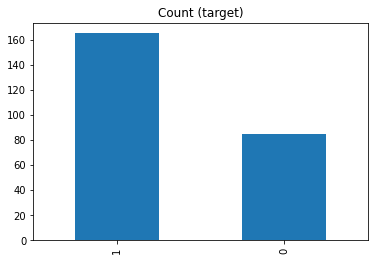

In [3]:
df_train['target'].value_counts().plot(kind='bar', title='Count (target)');

In [4]:
print(f"Train data Describe \n{df_train.describe()}\n")

Train data Describe 
              age         sex          cp    trestbps        chol         fbs  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean    54.080000    0.660000    1.072000  131.392000  247.524000    0.140000   
std      9.381773    0.474659    1.015352   17.399116   52.623096    0.347683   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.000000    0.000000    0.000000  120.000000  211.250000    0.000000   
50%     54.500000    1.000000    1.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

         restecg     thalach       exang     oldpeak       slope          ca  \
count  250.00000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.50400  152.472000    0.276000    0.944800    1.436000    0.628000   
std      

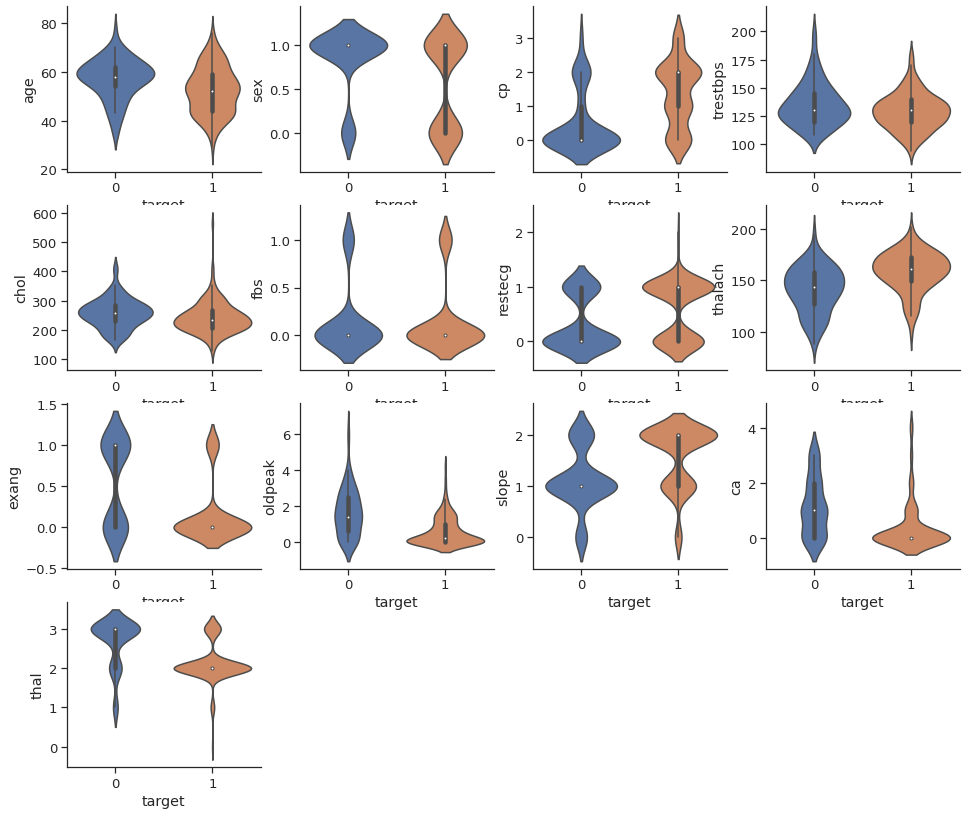

In [5]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal',]

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(4, 4, i+1)
    sns.violinplot(x="target",y=feature,data=df_train)
    
sns.despine()

In [6]:
df_train['chol*age']=df_train['chol']*df_train['age']
df_train['trestbps*cp']=df_train['trestbps']*df_train['cp']
df_train['trestbps*age']=df_train['trestbps']*df_train['age']

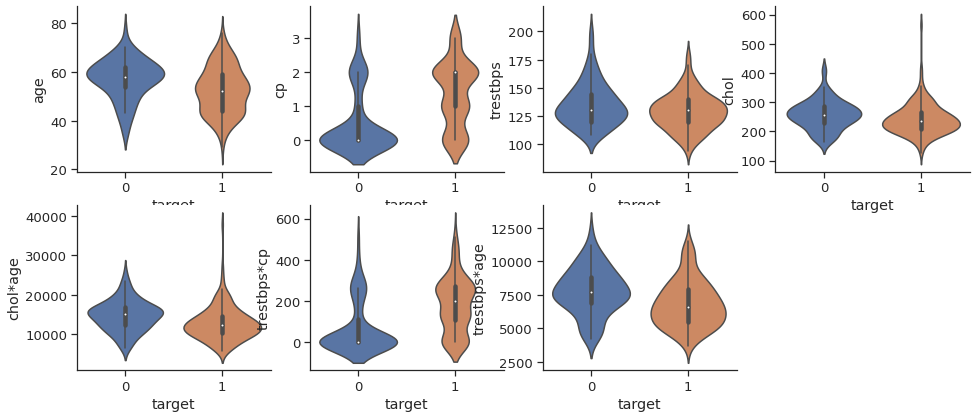

In [7]:
columns = ['age', 'cp', 'trestbps', 'chol', 'chol*age','trestbps*cp','trestbps*age']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(4, 4, i+1)
    sns.violinplot(x="target",y=feature,data=df_train)
    
sns.despine()

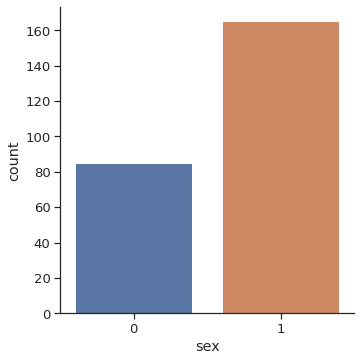

In [8]:
sns.catplot(x='sex', kind='count', data=df_train)
plt.show()
plt.close()

<AxesSubplot:>

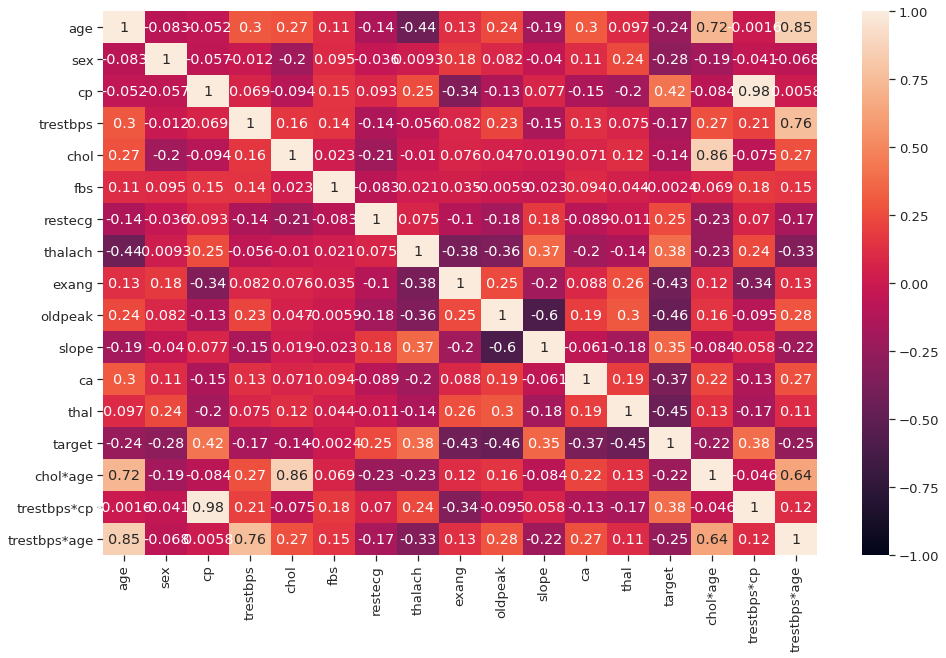

In [9]:
plt.figure(figsize=(16, 10))

heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap

In [10]:
num_vars=['age',  'trestbps', 'chol', 'thalach','oldpeak', 'chol*age', 'trestbps*cp', 'trestbps*age']
cat_vars=[ 'sex', 'cp', 'fbs', 'restecg','exang',  'slope', 'ca', 'thal' ]

In [11]:
df['sex'].unique().sum()

1

# Pipeline  for preprocess

In [12]:
from   category_encoders import target_encoder # import BinaryEncoder .target_encoder.TargetEncoder

num_4_Models = pipeline.Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('Normalizer',Normalizer(norm='max'))
])
cat_4_Models = pipeline.Pipeline(steps=[
  ('onehot', target_encoder.TargetEncoder( ))
])

preprocessor = compose.ColumnTransformer(transformers=[
    ('num', num_4_Models, num_vars),
    ('cat', cat_4_Models, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scalar', StandardScaler()),
                                                 ('Normalizer',
                                                  Normalizer(norm='max'))]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'chol*age', 'trestbps*cp',
                                  'trestbps*age']),
                                ('cat',
                                 Pipeline(steps=[('onehot', TargetEncoder())]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

# Models

In [13]:
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import SGDClassifier
classifier_models = {
'SVC':SVC(),
'SGDClassifier':SGDClassifier(),
'LinearSVC':LinearSVC(),
'KNeighborsClassifier':KNeighborsClassifier(20),
'LogisticRegression':LogisticRegression(),
"RandomForestClassifier":ensemble.RandomForestClassifier(),
"GradientBoostingClassifier":ensemble.GradientBoostingClassifier(),
}
# make pipline with  preprocessing 
classifier_models = {name: pipeline.make_pipeline(preprocessor, model) for name, model in classifier_models.items()}
classifier_models["GradientBoostingClassifier"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('Normalizer',
                                                                   Normalizer(norm='max'))]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'chol*age', 'trestbps*cp',
                                                   'trestbps*age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   TargetEncoder())]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [14]:

x=df_train.drop('target',axis=1)
y=df_train['target']
# x=data.drop('target',axis=1)
# y=data['target']
x_train, x_val, y_train, y_val = train_test_split(x, y,test_size=0.2,stratify = y,random_state=10 )
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [],'Time': []})
for model_name, model in classifier_models.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
    valid_pred = model.predict(x_val)
    results = results.append({"Model":    model_name,
                              "Accuracy": accuracy_score(y_val, valid_pred)*100,
                              "Bal Acc.": balanced_accuracy_score(y_val, valid_pred)*100,
                    
                              "Time":     total_time},
                              ignore_index=True)
results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,SVC,92.000000,91.087344,0.010714
2,LinearSVC,88.000000,88.057041,0.010805
3,LogisticRegression,88.000000,88.057041,0.013944
4,KNeighborsClassifier,86.000000,82.263815,0.006965
5,RandomForestClassifier,84.000000,86.452763,0.145802
6,GradientBoostingClassifier,84.000000,83.600713,0.101668
7,SGDClassifier,80.000000,74.866310,0.007935


In [15]:
from sklearn.metrics import classification_report,confusion_matrix
#with the best  paramaters
classifier=SVC()
tuning_model=Pipeline(steps=[('preprocessor', preprocessor),('classifier',classifier )])
tuning_model.fit(x_train,y_train)
pred=tuning_model.predict(x_val)
print("model score: %.3f" % tuning_model.score(x_val, y_val))
print(classification_report(y_val, pred))
print()
print(confusion_matrix(y_val, pred))

model score: 0.920
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.94      0.94      0.94        33

    accuracy                           0.92        50
   macro avg       0.91      0.91      0.91        50
weighted avg       0.92      0.92      0.92        50


[[15  2]
 [ 2 31]]


In [16]:
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

NameError: name 'X_train' is not defined

In [ ]:
import pickle as pkl
pkl.dump(model,open("model.p","wb"))

In [37]:
# Augmenting

import statistics
  
# Creating a sample of data
sample = [2.74, 1.23, 2.63, 2.22, 3, 1.98]
  
# Prints variance of the sample set
  
# Function will automatically calculate
# it's mean and set it as xbar
print("Variance of sample set is % s" 
      %(statistics.variance(sample)))

df

Variance of sample set is 0.40924


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Testing Data Augmentation Manually

In [70]:
added_age = np.random.randint(df['age'].min(), df['age'].max()+1, size=df.shape[0] // 2)
added_sex = np.random.randint(df['sex'].min(), df['sex'].max()+1, size=df.shape[0] // 2)
added_cp = np.random.randint(df['cp'].min(), df['cp'].max()+1, size=df.shape[0] // 2)
added_trestbps = np.random.randint(df['trestbps'].min(), df['trestbps'].max()+1, size=df.shape[0] // 2)
added_chol = np.random.randint(df['chol'].min(), df['chol'].max()+1, size=df.shape[0] // 2)
added_fbs = np.random.randint(df['fbs'].min(), df['fbs'].max()+1, size=df.shape[0] // 2)
added_restecg = np.random.randint(df['restecg'].min(), df['restecg'].max()+1, size=df.shape[0] // 2)

added_thalach = np.random.randint(df['thalach'].min(), df['thalach'].max()+1, size=df.shape[0] // 2)
added_exang = np.random.randint(df['exang'].min(), df['exang'].max()+1, size=df.shape[0] // 2)
added_oldpeak = np.random.randint(df['oldpeak'].min(), df['oldpeak'].max()+1, size=df.shape[0] // 2)
added_slope = np.random.randint(df['slope'].min(), df['slope'].max()+1, size=df.shape[0] // 2)
added_ca = np.random.randint(df['ca'].min(), df['ca'].max()+1, size=df.shape[0] // 2)
added_thal = np.random.randint(df['thal'].min(), df['thal'].max()+1, size=df.shape[0] // 2)
added_target = np.random.randint(df['target'].min(), df['target'].max()+1, size=df.shape[0] // 2)

added_sex

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [83]:
df_augmented = pd.DataFrame(added_age)
df_augmented['age'] = added_age
df_augmented['sex'] = added_sex
df_augmented['cp'] = added_cp
df_augmented['trestbps'] = added_trestbps
df_augmented['chol'] = added_chol
df_augmented['fbs'] = added_fbs
df_augmented['restecg'] = added_restecg

df_augmented['thalach'] = added_thalach
df_augmented['exang'] = added_exang
df_augmented['oldpeak'] = added_oldpeak
df_augmented['slope'] = added_slope
df_augmented['ca'] = added_ca
df_augmented['thal'] = added_thal
df_augmented['target'] = added_target

df_augmented = df_augmented.drop(columns=[0])

df_augmented


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,0,1,165,166,1,0,178,1,5,2,1,0,0
1,61,1,1,200,155,0,2,94,1,4,1,0,1,0
2,63,0,0,157,419,1,0,158,1,0,1,4,2,0
3,58,1,0,117,400,0,2,166,1,4,0,2,3,1
4,68,0,0,159,447,0,1,153,0,6,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,29,1,3,146,364,1,0,197,0,3,1,3,0,0
147,30,1,1,160,496,1,0,183,1,3,2,2,3,1
148,53,1,0,139,447,1,1,146,0,4,2,0,0,1
149,49,0,0,148,311,1,2,89,0,6,2,0,0,1


In [86]:
df_concat = pd.concat([df, df_augmented])
df_concat
# df_concat.isna().sum()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,29,1,3,146,364,1,0,197,0,3.0,1,3,0,0
147,30,1,1,160,496,1,0,183,1,3.0,2,2,3,1
148,53,1,0,139,447,1,1,146,0,4.0,2,0,0,1
149,49,0,0,148,311,1,2,89,0,6.0,2,0,0,1


In [90]:
### ONLY UNCOMMENT IF YOU WANT A NEW RANDOM SET OF DATA!

#df_concat.to_csv('df_concat.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd775439-f3d2-4e6d-9916-a56701a1b233' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>